마스크 데이터셋을 읽고 전처리를 진행한 후 데이터를 하나씩 꺼내주는 Dataset 클래스를 구현한 파일입니다.

이 곳에서, 나만의 Data Augmentation 기법 들을 구현하여 사용할 수 있습니다.

In [1]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models as models
from sklearn.metrics import f1_score
import torch.optim as optim
from PIL import Image
import pandas as pd
import numpy as np
import torch
import tqdm
import time
import os

In [2]:
MODEL_SAVE = r'/opt/ml/model'

In [3]:
get_data = pd.read_csv(r'/opt/ml/data/train/train.csv')
get_data = get_data.drop(['race','id'],axis=1)
get_data

gender  age                    path
0     female   45  000001_female_Asian_45
1     female   52  000002_female_Asian_52
2       male   54    000004_male_Asian_54
3     female   58  000005_female_Asian_58
4     female   59  000006_female_Asian_59
...      ...  ...                     ...
2695    male   19    006954_male_Asian_19
2696    male   19    006955_male_Asian_19
2697    male   19    006956_male_Asian_19
2698    male   20    006957_male_Asian_20
2699    male   19    006959_male_Asian_19

[2700 rows x 3 columns]

In [11]:
get_data.values

array([['female', 45, '000001_female_Asian_45'],
       ['female', 52, '000002_female_Asian_52'],
       ['male', 54, '000004_male_Asian_54'],
       ...,
       ['male', 19, '006956_male_Asian_19'],
       ['male', 20, '006957_male_Asian_20'],
       ['male', 19, '006959_male_Asian_19']], dtype=object)

In [4]:
TRAIN_DIR_ROOT = r'/opt/ml/data/train/images/'
TEST_DIR = r'/opt/ml/data/eval'
target = get_data.values
image_locate = [TRAIN_DIR_ROOT + i for i in get_data['path']]
images = []
for i in image_locate:
    temp = []
    for j in os.listdir(i):
        if not j[0] == '.':
            temp.append(i+'/'+j)
    images.append(temp)
images[:2]


[['/opt/ml/data/train/images/000001_female_Asian_45/mask3.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/mask4.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/incorrect_mask.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/mask1.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/mask5.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/mask2.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/normal.jpg'],
 ['/opt/ml/data/train/images/000002_female_Asian_52/mask3.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/mask4.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/incorrect_mask.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/mask1.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/mask5.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/mask2.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/normal.jpg']]

In [5]:
label_data = []
file_name_string = 'min'
labeled_dict = {"label": [],
                "gender": [],
                "age": [],
                "locate": []}
for i in images:
    for j in i:
        #/opt/ml/data/train/images/000002_female_Asian_52/normal.jpg 자른 것
        get_locate_file = j.split('/')
        #가장 끝의 파일은 이미지 이름이다.
        label = file_name_string.index(get_locate_file[-1][0])
        start = label * 6
        #000002_female_Asian_52 잘라서 굳이 위에 선언한 데이터 불러오지 않고 수행
        _, sex, _, age = get_locate_file[-2].split('_')
        age = int(age)
        if sex == 'female':
            start +=3
        if age < 30:
            pass
        elif age < 60:
            start +=1
        else:
            start +=2
        labeled_dict['label'].append(start)
        labeled_dict['gender'].append(sex)
        labeled_dict['age'].append(age)
        labeled_dict['locate'].append(j)

labeled_dict = pd.DataFrame(labeled_dict, columns=labeled_dict.keys())
labeled_dict

label  gender  age                                             locate
0          4  female   45  /opt/ml/data/train/images/000001_female_Asian_...
1          4  female   45  /opt/ml/data/train/images/000001_female_Asian_...
2         10  female   45  /opt/ml/data/train/images/000001_female_Asian_...
3          4  female   45  /opt/ml/data/train/images/000001_female_Asian_...
4          4  female   45  /opt/ml/data/train/images/000001_female_Asian_...
...      ...     ...  ...                                                ...
18895      6    male   19  /opt/ml/data/train/images/006959_male_Asian_19...
18896      0    male   19  /opt/ml/data/train/images/006959_male_Asian_19...
18897      0    male   19  /opt/ml/data/train/images/006959_male_Asian_19...
18898      0    male   19  /opt/ml/data/train/images/006959_male_Asian_19...
18899     12    male   19  /opt/ml/data/train/images/006959_male_Asian_19...

[18900 rows x 4 columns]

18900
12


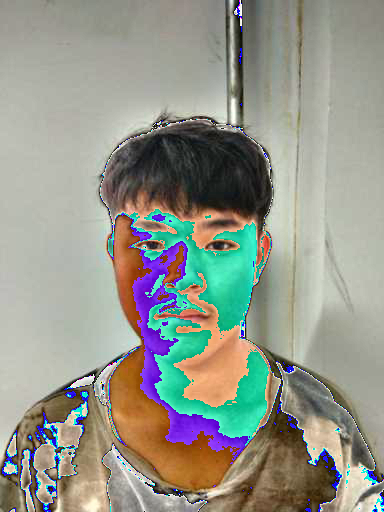

In [6]:
class MaskDataset(Dataset):
    def __init__(self, data, transform= None, train=True):
        self.data = data
        self.classes = self.data.columns.values.tolist()
        self.transform = transform
        self.train = train

    def __len__(self):
        return (len(self.data))

    def __getitem__(self, idx):
        X = Image.open(self.data['locate'].iloc[idx])

        if self.transform is not None:
            X = self.transform(X)
    
        if self.train:
            y = self.data['label'].iloc[idx]
            return X,y
        
        else:
            return X


datasets = MaskDataset(labeled_dict, 
transforms.Compose([
    # 선형 보간법을 사용하여 출력 픽셀값을 계산 -> 부드러운 느낌을 준다는데 누구 기준인진 잘
    transforms.Resize((512,384), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    ]),
    train=True)

print(len(datasets))
#tuple 로 반환하는거 확인
img,lb = datasets[18899]
print(lb)
im_pil = transforms.ToPILImage()(img)
im_pil


In [7]:
# 이거 안하면 마지막 인덱스에 붙어 나와서 서로 다른 인덱스로 잘라서 넣어주기 위함임
# def collate_function(data : tuple):
#     return tuple(zip(*data))

data_loader = DataLoader(datasets, batch_size=64, shuffle=True, num_workers=2)#, collate_fn=collate_function)
print(next(iter(data_loader))[1])

tensor([ 3,  3,  7,  6, 16,  4,  0,  4,  3,  0,  3,  3,  5, 13,  0,  1,  4,  4,
        15,  3,  3,  3,  4,  4,  1,  7,  4,  0, 16,  0,  1,  4,  4,  0,  4, 12,
         1,  4,  4,  1,  4,  0, 10,  3,  0,  4,  0,  1,  1, 13,  9,  0, 14,  4,
        10,  0,  4,  7,  3,  7, 13,  0, 13,  1])


In [11]:
test_models = models.detection.retinanet_resnet50_fpn(pretrained=True)
print(test_models)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bottleneck

In [16]:
import torch.nn as nn
class MaskModel(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.models = models.resnet18(pretrained=True)
        self.models.fc = nn.Linear(512, classes)
        print(f'network # input channel : {self.models.conv1.weight.size(1)}')
        print(f'network # output channel : {self.models.fc.weight.shape[0]}')

    def forward(self, x):
        logit = self.models(x)
        return logit

    def init_params(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                #kaiming_normal 에 대한 설명 -> 뭐가 좋아서 쓴 것인지
                nn.init.kaiming_normal_(module.weight)
                #BatchNorm2d 가 무엇인지 설명
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                nn.init.zeros_(module.bias)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using device : {device}')

lr = 0.001

model = MaskModel(18).to(device)
model.init_params()
#CrossEntropy(predict, y)
criterion = nn.CrossEntropyLoss()
optm = optim.Adam(model.parameters(), lr=lr)
print(model)

using device : cuda
network # input channel : 3
network # output channel : 18
MaskModel(
  (models): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [17]:
start_time = time.time()
for epoch in range(5):
    #바로 data_loader 값을 넣을 수 있음
    loss_value_sum = 0
    epoch_f1 = 0
    for i, (images, labels) in enumerate(tqdm.tqdm(data_loader, leave=False)):
        labels = torch.tensor(list(labels)).to(device)
        #gradient 초기화 : 이전 epoch 의 결과가 반영되면 안되기 때문 
        logits = model.forward(images.to(device))
        loss_out = criterion(logits, labels)

        #get f1_score
        _,predict = torch.max(logits,1)
        epoch_f1 += f1_score(labels.cpu().numpy(), predict.cpu().numpy(), average='macro')

        if i % 80 == 0:
            print(f'\tepoch : {epoch} loss {i} : {loss_out.data}')
        optm.zero_grad()
        loss_out.backward()
        optm.step()
        loss_value_sum += loss_out

    print(f'loss avg : {loss_value_sum/len(data_loader)}')
    print(f'f1_score per {epoch} : {epoch_f1/epoch:4f}')
end_time = time.time()
print(f'{(end_time - start_time)//60} minutes')


  0%|          | 0/296 [00:00<?, ?it/s]loss avg : 1.4156032800674438
f1_score per 0 :  inf
  0%|          | 0/296 [00:00<?, ?it/s]loss avg : 0.6166126132011414
f1_score per 1 : 187.362153
  0%|          | 0/296 [00:00<?, ?it/s]loss avg : 0.4475231170654297
f1_score per 2 : 103.989463
  0%|          | 0/296 [00:00<?, ?it/s]loss avg : 0.35730651021003723
f1_score per 3 : 74.071644
 81%|████████▏ | 241/296 [01:07<00:15,  3.62it/s]	epoch : 4 loss 240 : 0.18697164952754974
                                                 loss avg : 0.29847609996795654
f1_score per 4 : 58.379071
6.0 minutes
